# Simple pyro timeseries prediction

In [34]:
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
#from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest, eval_crps
from pyro.infer.reparam import LocScaleReparam, StableReparam
from pyro.ops.tensor_utils import periodic_cumsum, periodic_repeat, periodic_features
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
assert pyro.__version__.startswith('1.6.0')
pyro.set_rng_seed(20200221)

In [36]:
from pyro.contrib import examples


In [55]:
row_data = pd.read_csv('../../data/3/data/total_mass.csv', index_col=0, parse_dates=True)
row_data = row_data.replace(0, np.nan).interpolate()

In [56]:
data = torch.Tensor(row_data.values)
print(data.shape)

torch.Size([120, 1])


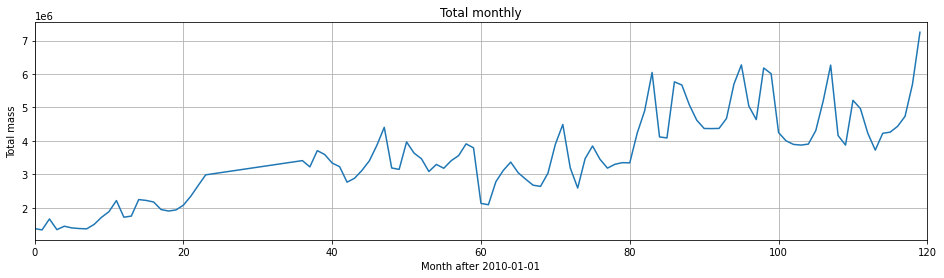

In [57]:
plt.figure(figsize=(16, 4))
plt.plot(data)
plt.grid()
plt.title("Total monthly")
plt.ylabel("Total mass")
plt.xlabel("Month after 2010-01-01")
plt.xlim(0, len(data));

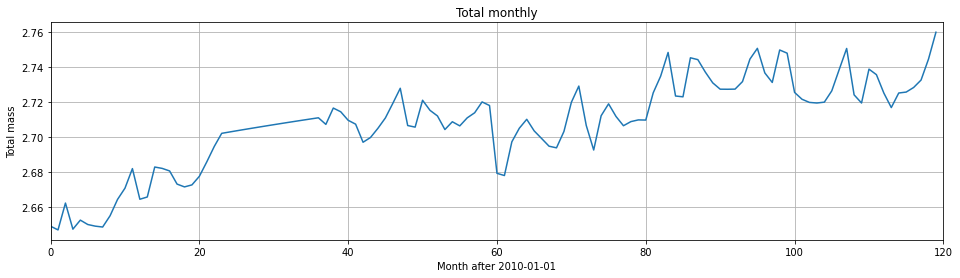

In [72]:
data = data.log()
plt.figure(figsize=(16, 4))
plt.plot(data.log())
plt.grid()
plt.title("Total monthly")
plt.ylabel("Total mass")
plt.xlabel("Month after 2010-01-01")
plt.xlim(0, len(data));

In [53]:
# First we need some boilerplate to create a class and define a .model() method.
class Model1(ForecastingModel):
    # We then implement the .model() method. Since this is a generative model, it shouldn't
    # look at data; however it is convenient to see the shape of data we're supposed to
    # generate, so this inputs a zeros_like(data) tensor instead of the actual data.
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)  # Should be 1 in this univariate tutorial.
        feature_dim = covariates.size(-1)

        # The first part of the model is a probabilistic program to create a prediction.
        # We use the zero_data as a template for the shape of the prediction.
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))
        prediction = bias + (weight * covariates).sum(-1, keepdim=True)
        # The prediction should have the same shape as zero_data (duration, obs_dim),
        # but may have additional sample dimensions on the left.
        assert prediction.shape[-2:] == zero_data.shape

        # The next part of the model creates a likelihood or noise distribution.
        # Again we'll be Bayesian and write this as a probabilistic program with
        # priors over parameters.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)

        # The final step is to call the .predict() method.
        self.predict(noise_dist, prediction)

In [128]:
predict_period = 0
test_period = 12
T0 = 0                                      # begining
T2 = data.size(-2) + predict_period         # end
T1 = T2 - (predict_period + test_period)    # train/test split

In [130]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
# why 365?
time = torch.arange(float(T2)) / 365
covariates = torch.stack([time], dim=-1)
forecaster = Forecaster(Model1(), data[:T1], covariates[:T1], learning_rate=0.1)

INFO 	 step    0 loss = 527472
INFO 	 step  100 loss = 0.584596
INFO 	 step  200 loss = 0.546858
INFO 	 step  300 loss = 0.524076
INFO 	 step  400 loss = 0.535524
INFO 	 step  500 loss = 0.538587
INFO 	 step  600 loss = 0.518165
INFO 	 step  700 loss = 0.523545
INFO 	 step  800 loss = 0.520557
INFO 	 step  900 loss = 0.525713
INFO 	 step 1000 loss = 0.528997


CPU times: user 4.68 s, sys: 7.97 ms, total: 4.69 s
Wall time: 4.68 s


torch.Size([1000, 12, 1]) torch.Size([12])


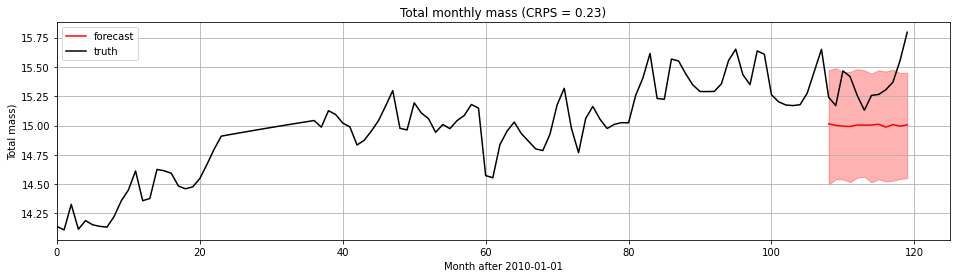

In [131]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(16, 4))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total monthly mass (CRPS = {:0.3g})".format(crps))
plt.ylabel("Total mass)")
plt.xlabel("Month after 2010-01-01")
plt.xlim(0, None)
plt.grid()
plt.legend(loc="best");

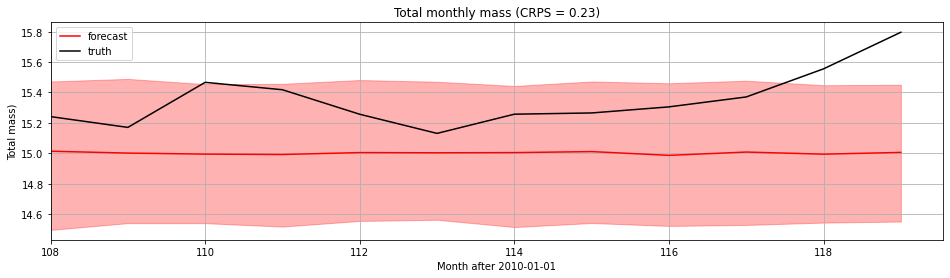

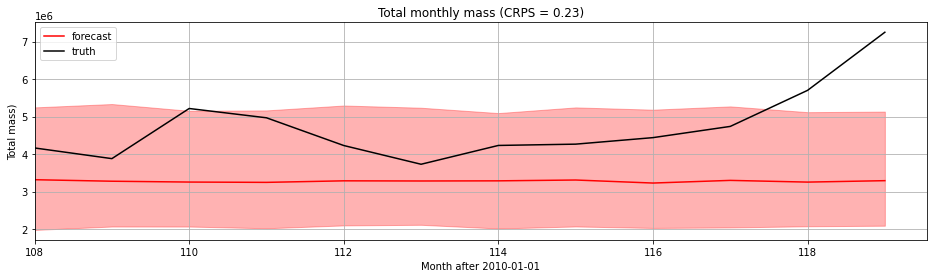

In [135]:
plt.figure(figsize=(16, 4))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total monthly mass (CRPS = {:0.3g})".format(crps))
plt.ylabel("Total mass)")
plt.xlabel("Month after 2010-01-01")
plt.xlim(T1, None)
plt.grid()
plt.legend(loc="best");

plt.figure(figsize=(16, 4))
plt.fill_between(torch.arange(T1, T2), p10.exp(), p90.exp(), color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50.exp(), 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:].exp(), 'k-', label='truth')
plt.title("Total monthly mass (CRPS = {:0.3g})".format(crps))
plt.ylabel("Total mass)")
plt.xlabel("Month after 2010-01-01")
plt.xlim(T1, None)
plt.grid()
plt.legend(loc="best");

In [136]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = torch.cat([time.unsqueeze(-1),
                        periodic_features(T2, 365.25 / 30.5)], dim=-1)
forecaster = Forecaster(Model1(), data[:T1], covariates[:T1], learning_rate=0.1)

INFO 	 step    0 loss = 6.11612e+06
INFO 	 step  100 loss = 3.03108
INFO 	 step  200 loss = 0.590512
INFO 	 step  300 loss = 0.600655
INFO 	 step  400 loss = 0.60656
INFO 	 step  500 loss = 0.566338
INFO 	 step  600 loss = 0.588759
INFO 	 step  700 loss = 0.582484
INFO 	 step  800 loss = 0.555006
INFO 	 step  900 loss = 0.552681
INFO 	 step 1000 loss = 0.563279


CPU times: user 4.62 s, sys: 4.01 ms, total: 4.62 s
Wall time: 4.62 s


torch.Size([1000, 12, 1]) torch.Size([12])


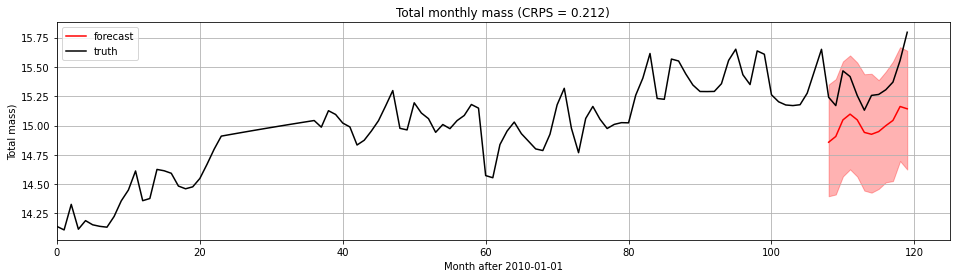

In [138]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(16, 4))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total monthly mass (CRPS = {:0.3g})".format(crps))
plt.ylabel("Total mass)")
plt.xlabel("Month after 2010-01-01")
plt.xlim(0, None)
plt.grid()
plt.legend(loc="best");

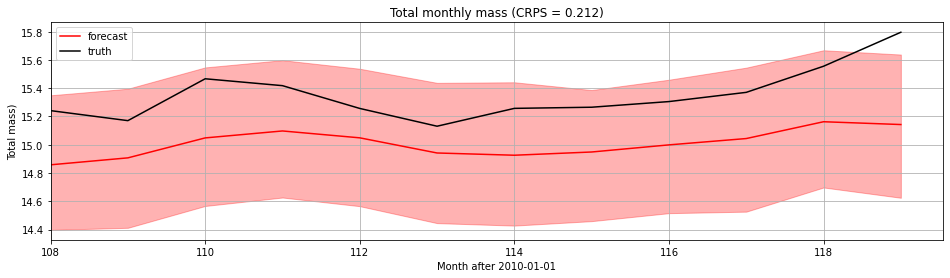

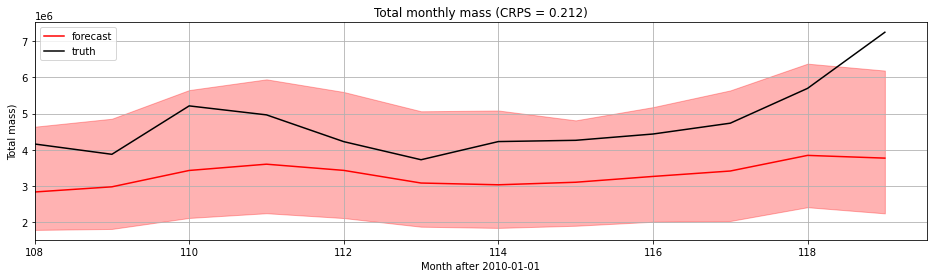

In [139]:
plt.figure(figsize=(16, 4))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total monthly mass (CRPS = {:0.3g})".format(crps))
plt.ylabel("Total mass)")
plt.xlabel("Month after 2010-01-01")
plt.xlim(T1, None)
plt.grid()
plt.legend(loc="best");

plt.figure(figsize=(16, 4))
plt.fill_between(torch.arange(T1, T2), p10.exp(), p90.exp(), color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50.exp(), 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:].exp(), 'k-', label='truth')
plt.title("Total monthly mass (CRPS = {:0.3g})".format(crps))
plt.ylabel("Total mass)")
plt.xlabel("Month after 2010-01-01")
plt.xlim(T1, None)
plt.grid()
plt.legend(loc="best");

In [140]:
class Model2(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))

        # We'll sample a time-global scale parameter outside the time plate,
        # then time-local iid noise inside the time plate.
        drift_scale = pyro.sample("drift_scale",
                                  dist.LogNormal(-20, 5).expand([1]).to_event(1))
        with self.time_plate:
            # We'll use a reparameterizer to improve variational fit. The model would still be
            # correct if you removed this context manager, but the fit appears to be worse.
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(zero_data, drift_scale).to_event(1))

        # After we sample the iid "drift" noise we can combine it in any time-dependent way.
        # It is important to keep everything inside the plate independent and apply dependent
        # transforms outside the plate.
        motion = drift.cumsum(-2)  # A Brownian motion.

        # The prediction now includes three terms.
        prediction = motion + bias + (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape

        # Construct the noise distribution and predict.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)
        self.predict(noise_dist, prediction)

In [141]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = periodic_features(T2, 365.25 / 30.5)
forecaster = Forecaster(Model2(), data[:T1], covariates[:T1], learning_rate=0.1,
                        time_reparam="dct",
                       )

INFO 	 step    0 loss = 4.75354e+11
INFO 	 step  100 loss = 29.8796
INFO 	 step  200 loss = 0.87337
INFO 	 step  300 loss = 0.748518
INFO 	 step  400 loss = 0.721967
INFO 	 step  500 loss = 0.686861
INFO 	 step  600 loss = 0.663608
INFO 	 step  700 loss = 0.620524
INFO 	 step  800 loss = 0.676691
INFO 	 step  900 loss = 0.652665
INFO 	 step 1000 loss = 0.597977


CPU times: user 9.02 s, sys: 0 ns, total: 9.02 s
Wall time: 9.02 s


torch.Size([1000, 12, 1]) torch.Size([12])


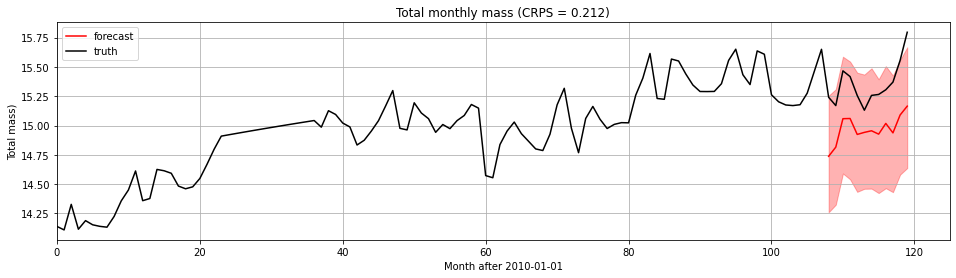

In [142]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
#crps = eval_crps(samples, data[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(16, 4))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total monthly mass (CRPS = {:0.3g})".format(crps))
plt.ylabel("Total mass)")
plt.xlabel("Month after 2010-01-01")
plt.xlim(0, None)
plt.grid()
plt.legend(loc="best");

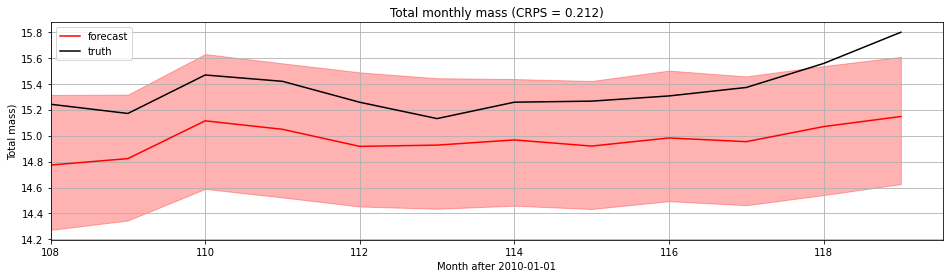

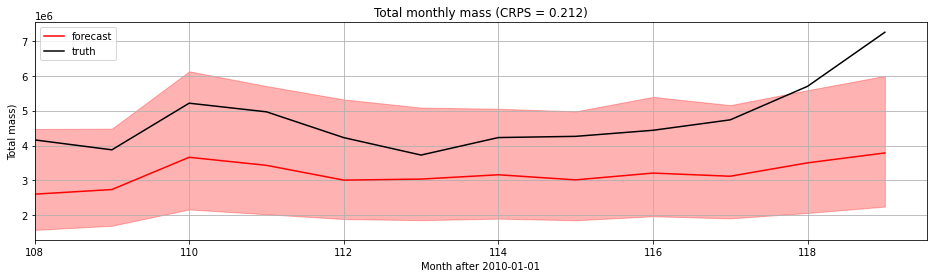

In [144]:
plt.figure(figsize=(16, 4))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total monthly mass (CRPS = {:0.3g})".format(crps))
plt.ylabel("Total mass)")
plt.xlabel("Month after 2010-01-01")
plt.xlim(T1, None)
plt.grid()
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(16, 4))
plt.fill_between(torch.arange(T1, T2), p10.exp(), p90.exp(), color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50.exp(), 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:].exp(), 'k-', label='truth')
plt.title("Total monthly mass (CRPS = {:0.3g})".format(crps))
plt.ylabel("Total mass)")
plt.xlabel("Month after 2010-01-01")
plt.xlim(T1, None)
plt.grid()
plt.legend(loc="best")
plt.show()

In [145]:
class Model3(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-20, 5).expand([1]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(zero_data, drift_scale).to_event(1))
        motion = drift.cumsum(-2)  # A Brownian motion.

        prediction = motion + bias + (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape

        # The next part of the model creates a likelihood or noise distribution.
        # Again we'll be Bayesian and write this as a probabilistic program with
        # priors over parameters.
        stability = pyro.sample("noise_stability", dist.Uniform(1, 2).expand([1]).to_event(1))
        skew = pyro.sample("noise_skew", dist.Uniform(-1, 1).expand([1]).to_event(1))
        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Stable(stability, skew, scale)

        # We need to use a reparameterizer to handle the Stable distribution.
        # Note "residual" is the name of Pyro's internal sample site in self.predict().
        with poutine.reparam(config={"residual": StableReparam()}):
            self.predict(noise_dist, prediction)

In [146]:
%%time
pyro.set_rng_seed(2)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = periodic_features(T2, 365.25 / 30.5)
forecaster = Forecaster(Model3(), data[:T1], covariates[:T1], learning_rate=0.1,
                        time_reparam="dct")
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 75424.2
INFO 	 step  100 loss = 3.31465
INFO 	 step  200 loss = 1.07263
INFO 	 step  300 loss = 1.18378
INFO 	 step  400 loss = 1.08415
INFO 	 step  500 loss = 0.95783
INFO 	 step  600 loss = 0.849219
INFO 	 step  700 loss = 1.06975
INFO 	 step  800 loss = 1.03294
INFO 	 step  900 loss = 1.07828
INFO 	 step 1000 loss = 1.16731


bias = 14.95
drift_scale = 6.033e-07
noise_stability = 1.954
noise_skew = -0.02195
noise_scale = 0.2683
CPU times: user 17.8 s, sys: 15.9 ms, total: 17.8 s
Wall time: 17.8 s


torch.Size([1000, 12, 1]) torch.Size([12])


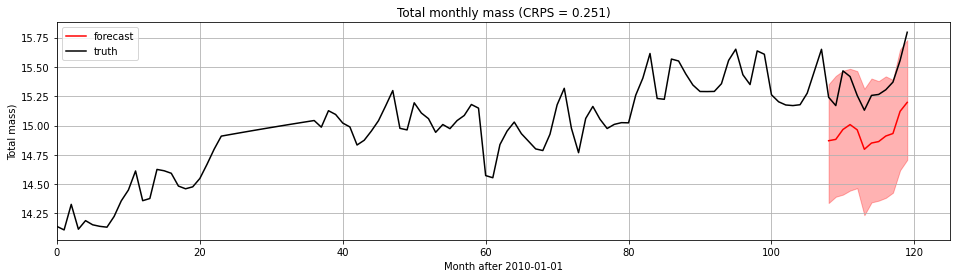

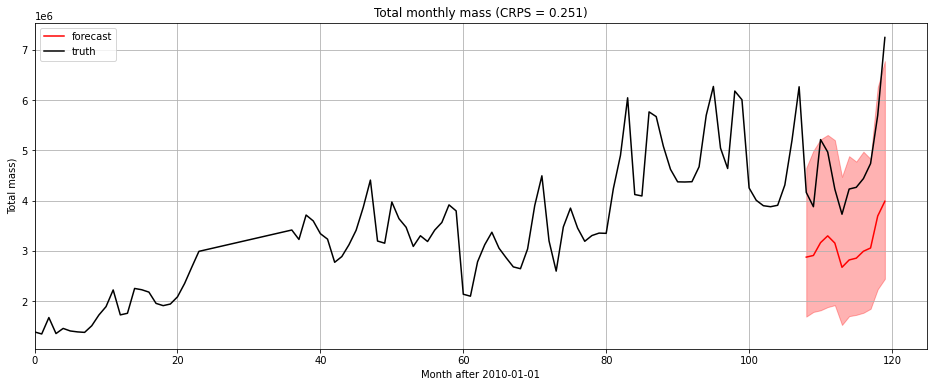

In [151]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(16, 4))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total monthly mass (CRPS = {:0.3g})".format(crps))
plt.ylabel("Total mass)")
plt.xlabel("Month after 2010-01-01")
plt.xlim(0, None)
plt.grid()
plt.legend(loc="best");

plt.figure(figsize=(16, 6))
plt.fill_between(torch.arange(T1, T2), p10.exp(), p90.exp(), color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50.exp(), 'r-', label='forecast')
plt.plot(data.exp(), 'k-', label='truth')
plt.title("Total monthly mass (CRPS = {:0.3g})".format(crps))
plt.ylabel("Total mass)")
plt.xlabel("Month after 2010-01-01")
plt.xlim(0, None)
plt.grid()
plt.legend(loc="best");

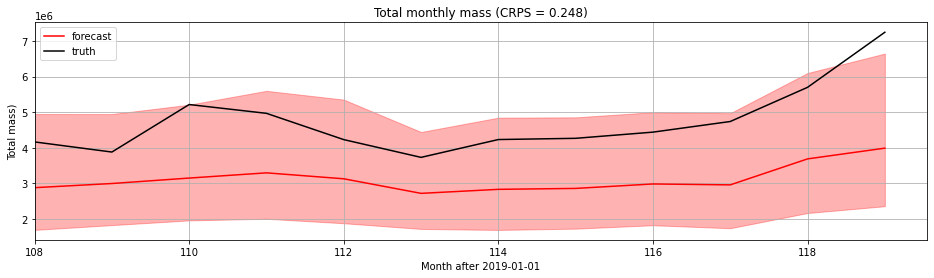

In [149]:
# plt.figure(figsize=(16, 4))
# plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
# plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
# plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
# plt.title("Total monthly mass (CRPS = {:0.3g})".format(crps))
# plt.ylabel("Total mass)")
# plt.xlabel("Month after 2019-01-01")
# plt.xlim(T1, None)
# plt.grid()
# plt.legend(loc="best");

plt.figure(figsize=(16, 4))
plt.fill_between(torch.arange(T1, T2), p10.exp(), p90.exp(), color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50.exp(), 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:].exp(), 'k-', label='truth')
plt.title("Total monthly mass (CRPS = {:0.3g})".format(crps))
plt.ylabel("Total mass)")
plt.xlabel("Month after 2019-01-01")
plt.xlim(T1, None)
plt.grid()
plt.legend(loc="best");

# Backstaging

In [98]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
windows2 = backtest(data, covariates, Model2,
                    min_train_window=24, test_window=12, stride=6,
                    forecaster_options={"learning_rate": 0.1, "time_reparam": "dct",
                                        "log_every": 1000, "warm_start": True})

INFO 	 Training on window [0:24], testing on window [24:36]
INFO 	 step    0 loss = 7637.35
INFO 	 step 1000 loss = 0.69998
INFO 	 Training on window [0:30], testing on window [30:42]
INFO 	 step    0 loss = 1.00917
INFO 	 step 1000 loss = 0.70665
INFO 	 Training on window [0:36], testing on window [36:48]
INFO 	 step    0 loss = 1.29158
INFO 	 step 1000 loss = 0.707536
INFO 	 Training on window [0:42], testing on window [42:54]
INFO 	 step    0 loss = 1.16536
INFO 	 step 1000 loss = 0.733949
INFO 	 Training on window [0:48], testing on window [48:60]
INFO 	 step    0 loss = 1.07332
INFO 	 step 1000 loss = 0.67854
INFO 	 Training on window [0:54], testing on window [54:66]
INFO 	 step    0 loss = 1.00655
INFO 	 step 1000 loss = 0.620741
INFO 	 Training on window [0:60], testing on window [60:72]
INFO 	 step    0 loss = 0.918653
INFO 	 step 1000 loss = 0.660561
INFO 	 Training on window [0:66], testing on window [66:78]
INFO 	 step    0 loss = 0.781604
INFO 	 step 1000 loss = 0.571738
I

CPU times: user 2min 14s, sys: 23.2 ms, total: 2min 14s
Wall time: 2min 13s


In [99]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
windows3 = backtest(data, covariates, Model3,
                    min_train_window=24, test_window=12, stride=6,
                    forecaster_options={"learning_rate": 0.1, "time_reparam": "dct",
                                        "log_every": 1000, "warm_start": True})

INFO 	 Training on window [0:24], testing on window [24:36]
INFO 	 step    0 loss = 1.47269e+16
INFO 	 step 1000 loss = 1.18461
INFO 	 Training on window [0:30], testing on window [30:42]
INFO 	 step    0 loss = 4.88205
INFO 	 step 1000 loss = 0.833129
INFO 	 Training on window [0:36], testing on window [36:48]
INFO 	 step    0 loss = 4.07123
INFO 	 step 1000 loss = 0.77205
INFO 	 Training on window [0:42], testing on window [42:54]
INFO 	 step    0 loss = 2.35472
INFO 	 step 1000 loss = 0.534862
INFO 	 Training on window [0:48], testing on window [48:60]
INFO 	 step    0 loss = 3.82881
INFO 	 step 1000 loss = 0.117524
INFO 	 Training on window [0:54], testing on window [54:66]
INFO 	 step    0 loss = 1.25124
INFO 	 step 1000 loss = 0.194661
INFO 	 Training on window [0:60], testing on window [60:72]
INFO 	 step    0 loss = 1.16603
INFO 	 step 1000 loss = 0.118026
INFO 	 Training on window [0:66], testing on window [66:78]
INFO 	 step    0 loss = 5.40552
INFO 	 step 1000 loss = 0.09908

CPU times: user 4min 27s, sys: 257 ms, total: 4min 27s
Wall time: 4min 26s


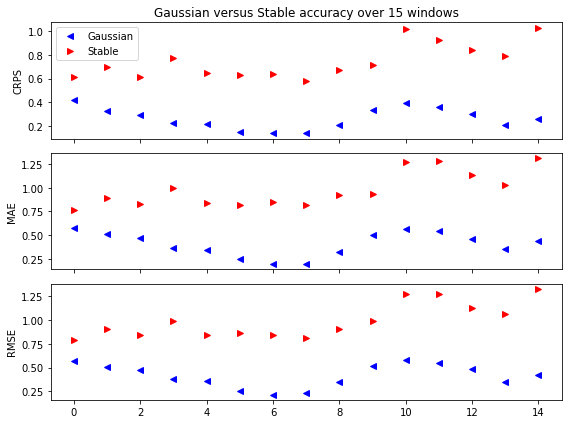

In [100]:
fig, axes = plt.subplots(3, figsize=(16, 9), sharex=True)
axes[0].set_title("Gaussian versus Stable accuracy over {} windows".format(len(windows2)))
axes[0].plot([w["crps"] for w in windows2], "b<", label="Gaussian")
axes[0].plot([w["crps"] for w in windows3], "r>", label="Stable")
axes[0].set_ylabel("CRPS")
axes[1].plot([w["mae"] for w in windows2], "b<", label="Gaussian")
axes[1].plot([w["mae"] for w in windows3], "r>", label="Stable")
axes[1].set_ylabel("MAE")
axes[2].plot([w["rmse"] for w in windows2], "b<", label="Gaussian")
axes[2].plot([w["rmse"] for w in windows3], "r>", label="Stable")
axes[2].set_ylabel("RMSE")
axes[0].legend(loc="best")
plt.tight_layout()